In [33]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Flatten
import psutil

In [34]:
from memory_profiler import memory_usage

In [35]:
path='/content/drive/MyDrive/Colab Notebooks/Mat.1.csv'
df=pd.read_csv(path)

In [36]:
df

,Job samples,CPU,Memory,Reward,CPU used,Memory used
0,10,60,100,NaN,NaN,NaN
1,15,50,160,NaN,NaN,NaN
2,13,65,200,NaN,NaN,NaN
3,16,55,140,NaN,NaN,NaN
4,8,78,220,NaN,NaN,NaN
5,11,80,260,NaN,NaN,NaN
6,2,62,140,NaN,NaN,NaN
7,17,54,180,NaN,NaN,NaN
8,12,65,340,NaN,NaN,NaN
9,9,66,280,NaN,NaN,NaN


In [39]:
class env:
    rand_seed = 10
    def __init__(self, resources, num_tasks):
        np.random.seed(self.rand_seed)
        self.state_ = np.zeros((num_tasks, 1), dtype=int)
        self.limit_ = 0
        for lim in resources:
            self.state_ = np.append(self.state_, np.random.randint(lim, size=(num_tasks, 1)), axis=1)    
        self.reward_ = 0
        for lim in resources:
            self.limit_+=lim         
        self.num_tasks_ = num_tasks
        self.resources_ = resources   
    def get_initial_state(self):
        state = np.zeros((self.num_tasks_, len(self.resources_) + 1), dtype=int)
        for lim in self.resources_: 
            state = np.append(state, np.random.randint(lim, size=(self.num_tasks_,1)), axis=1)
        self.state_ = state
        self.reward_ = 0
        return self.state_
    def getSum(self, x ):
        if x[0] == 1:
            return sum(x)-1
        else:
            return 0
    def get_next_step(self, actionIdx):        
        self.reward_ = 0
        reward = 0
        done = False        
        if self.state_[actionIdx][0] == 1:
            sum_res = np.sum(self.state_[actionIdx], axis=0)
            reward = -sum_res/10;
        else:
            self.state_[actionIdx][0] = 1        
        totReward = sum(np.apply_along_axis( self.getSum, axis=1, arr=self.state_ ))
        sum_res = np.sum(self.state_[actionIdx], axis=0) 
        if totReward <= self.limit_:
            reward = sum_res
        else:
            reward = -sum_res/10;
            done = True
        return self.state_,reward,done 
xyz = []
xyz1 = []
xyz2 = []
for j in range(df.shape[0]):
  resources = [df.iat[j, 1], df.iat[j, 2]]
  num_tasks = 5
  en = env(resources,num_tasks)
  mem_usage_before = memory_usage(-1, interval=1)[0]
  cpu_usage_before = psutil.cpu_percent(interval=None)
  input_layer_n = num_tasks
  output_layer_n = 5
  dense_layer_n = 10
  model = Sequential()
  model.add(Flatten(input_shape=(5, 5)))
  model.add(InputLayer(batch_input_shape=(1, len(resources) + 1)))
  model.add(Dense(dense_layer_n, activation='sigmoid'))
  model.add(Dense(output_layer_n, activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  num_job_samples = df.iat[j, 0]
  y = 0.95
  eps = 0.5
  decay_factor = 0.999
  r_avg_list = []
  for i in range(num_job_samples):
      s = en.get_initial_state()
      eps *= decay_factor
      if i % 100 == 0:
          print("Episode {} of {}".format(i + 1, num_job_samples))
      scheduled = False
      r_sum = 0
      while not scheduled:
          if np.random.random() < eps:
              a = np.random.randint(0, 5) 
          else:
              s_expanded = np.expand_dims(s, axis=0)  # add extra dimension to match model input shape
              q_values = model.predict(s_expanded)[0]  # get Q-values for all actions
              a = np.argmax(q_values)  # choose action with highest Q-value
          new_s, r, scheduled = en.get_next_step(a) 
          target = r + y * np.max(model.predict(np.expand_dims(new_s, axis=0)))  # add extra dimension to match model input shape
          target_vec = model.predict(np.expand_dims(s, axis=0))[0]  # get Q-values for current state
          target_vec[a] = target
          model.fit(np.expand_dims(s, axis=0), np.expand_dims(target_vec, axis=0), epochs=1, verbose=0)  # add extra dimension to match model input shape
          s = new_s
          r_sum += r
      r_avg_list.append(r_sum / num_tasks)
      print("Total reward for episode {}: {}".format(i + 1, r_sum))
  k=sum(r_avg_list) / len(r_avg_list)
  xyz.append(k)
  df.iat[j, 3] = k 
  mem_usage_after = memory_usage(-1, interval=1)[0]
 
  cpu_usage_after = psutil.cpu_percent(interval=None)
  mem=mem_usage_after-mem_usage_before
  cpu=cpu_usage_after-cpu_usage_before
  xyz1.append(cpu)
  df.iat[j, 4] = cpu
  xyz2.append(mem)
  df.iat[j, 5] = mem
  print(f"Memory usage (Iteration {j}): {mem_usage_after-mem_usage_before}MiB")
  print(f"CPU usage (Iteration {j}): {cpu_usage_after-cpu_usage_before}%")
  print("Average reward per task after {} episodes: {}".format(num_job_samples, sum(r_avg_list) / len(r_avg_list)))

Episode 1 of 10
1/1 [==============================] - 0s 36ms/step
Total reward for episode 1: 359.7
1/1 [==============================] - 0s 27ms/step
Total reward for episode 2: 431.2
1/1 [==============================] - 0s 23ms/step
Total reward for episode 3: 350.9
1/1 [==============================] - 0s 26ms/step
Total reward for episode 4: 97.5
1/1 [==============================] - 0s 24ms/step
Total reward for episode 5: 824.4
1/1 [==============================] - 0s 27ms/step
Total reward for episode 6: 104.4
1/1 [==============================] - 0s 27ms/step
Total reward for episode 7: 141.7
1/1 [==============================] - 0s 44ms/step
Total reward for episode 8: 139.7
1/1 [==============================] - 0s 63ms/step
Total reward for episode 9: 107.4
1/1 [==============================] - 0s 34ms/step
Total reward for episode 10: 763.9
Memory usage (Iteration 0): 48.953125MiB
CPU usage (Iteration 0): 36.5%
Average reward per task after 10 episodes: 66.416
Ep

In [40]:
print(df)
print(xyz)
print(xyz1)
print(xyz2)

    Job samples  CPU  Memory      Reward  CPU used  Memory used
0            10   60     100   66.416000      36.5    48.953125
1            15   50     160   76.812000      63.4    52.078125
2            13   65     200   71.955385      48.1    53.589844
3            16   55     140   60.327500      31.2    64.261719
4             8   78     220   60.197500      59.9     2.628906
5            11   80     260  110.789091      65.1    69.800781
6             2   62     140   97.350000      69.9    17.605469
7            17   54     180   76.637647      66.8    75.890625
8            12   65     340  160.376667      34.1    25.746094
9             9   66     280  102.368889      16.3    44.640625
10            1   76     360   40.240000      34.5     7.941406
11            5   77     180   82.528000      68.5    33.195312
12           19   74     280  118.649474      75.3    56.687500
13            7   58     260   82.522857      69.1    41.531250
14            3   64     380  110.640000

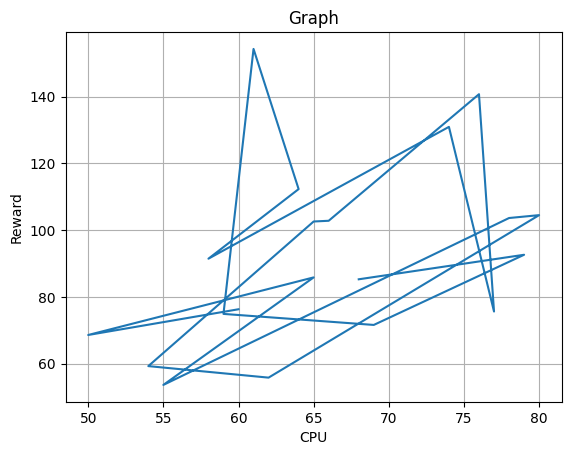

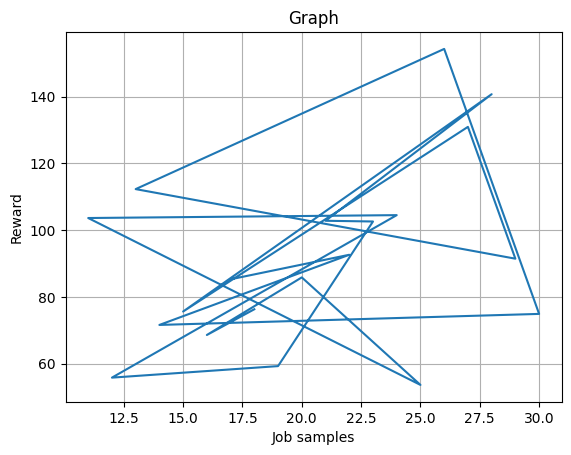

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.DataFrame(df)

# create a line graph
plt.plot(df1['CPU'], df1['Reward'])
plt.grid(True)
# add labels and title
plt.xlabel('CPU')
plt.ylabel('Reward')
plt.title('Graph')

# display the graph
plt.show()

#graph2
# create a line graph
plt.plot(df1['Job samples'], df1['Reward'])
plt.grid(True)
# add labels and title
plt.xlabel('Job samples')
plt.ylabel('Reward')
plt.title('Graph')

# display the graph
plt.show()
#graph3
# # create a line graph
# plt.plot(df1['Memory'], df1['Reward'])
# plt.grid(True)
# # add labels and title
# plt.xlabel('Memory')
# plt.ylabel('Reward')
# plt.title('Graph')

# # display the graph
# plt.show()

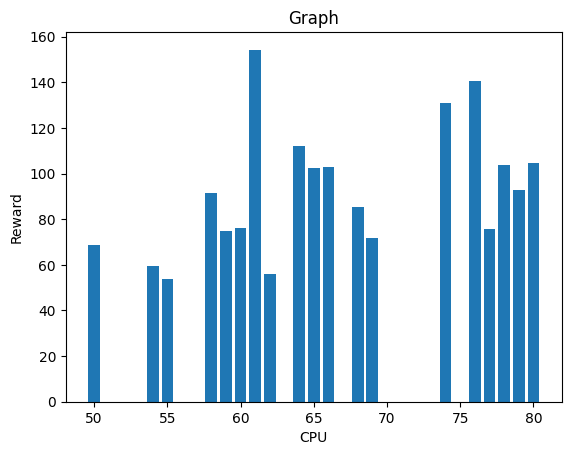

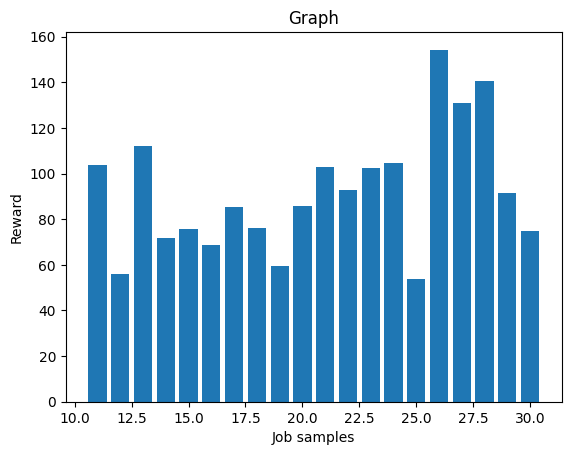

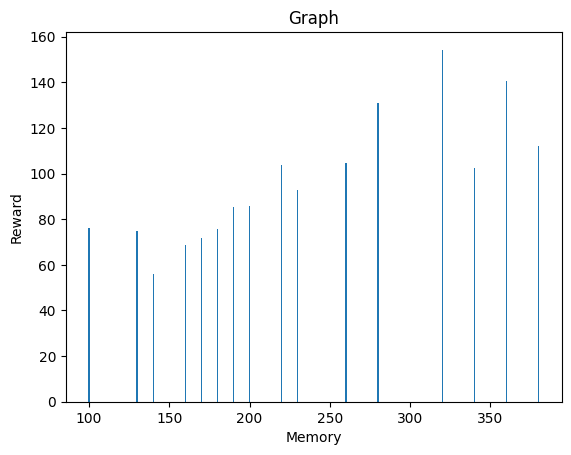

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.DataFrame(df)

#graph1
plt.bar(df1['CPU'], df1['Reward'])    # create a line graph
# add labels and title
plt.xlabel('CPU')
plt.ylabel('Reward')
plt.title('Graph')
plt.show()    # display the graph

#graph2
plt.bar(df1['Job samples'], df1['Reward'])   # create a line graph
# add labels and title
plt.xlabel('Job samples')
plt.ylabel('Reward')
plt.title('Graph')
plt.show()   # display the graph

#graph3
plt.bar(df1['Memory'], df1['Reward'])    # create a line graph
# add labels and title
plt.xlabel('Memory')
plt.ylabel('Reward')
plt.title('Graph')
plt.show()     # display the graph